In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from collections import OrderedDict
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tfomics.layers import RevCompConv1D
import matplotlib.pyplot as plt
from six.moves import cPickle as pk
from scipy import stats

In [2]:
class RevCompConv1D(tf.keras.layers.Conv1D):
    """
    Implement forward and reverse-complement filter convolutions
    for 1D signals. It takes as input either a single input or two inputs 
    (where the second input is the reverse complement scan). If a single input, 
    this performs both forward and reverse complement scans and either merges it 
    (if concat=True) or returns a separate scan for forward and reverse comp. 
    """
    def __init__(self, *args, concat=True, **kwargs):
        super(RevCompConv1D, self).__init__(*args, **kwargs)
        self.concat = concat


    def call(self, inputs, inputs2=None):

        if inputs2 is not None:
          # create rc_kernels
            rc_kernel = self.kernel[::-1,::-1,:]

            # convolution 1D
            outputs = self.convolution_op(inputs, self.kernel)
            rc_outputs = self.convolution_op(inputs2, rc_kernel)

        else:
          # create rc_kernels
            rc_kernel = tf.concat([self.kernel, self.kernel[::-1,:,:][:,::-1,:]], axis=-1)

            # convolution 1D
            outputs = self._convolution_op(inputs, rc_kernel)

            # unstack to forward and reverse strands
            outputs = tf.unstack(outputs, axis=2)
            rc_outputs = tf.stack(outputs[self.filters:], axis=2)
            outputs = tf.stack(outputs[:self.filters], axis=2)

        # add bias
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
            rc_outputs = tf.nn.bias_add(rc_outputs, self.bias)

        # add activations
        if self.activation is not None:
            outputs = self.activation(outputs)
            rc_outputs = self.activation(rc_outputs)

        if self.concat:
            return tf.concat([outputs, rc_outputs], axis=-1)
        else:
            return outputs, rc_outputs

In [3]:
class ProfileModel(tf.keras.Model):
    
    def __init__(self, bin_size=1, rc_prob=0.5, *args, **kwargs):
        super(ProfileModel, self).__init__(*args, **kwargs)
        self.bin_size = bin_size
        self.rc_prob = rc_prob

    def get_config(self):
        config = super(ProfileModel, self).get_config()
        config.update({"bin_size": self.bin_size})
        config.update({'rc_prob': self.rc_prob})
        return config

    def train_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        # online target resolution calculation
        y = bin_resolution(y, self.bin_size)

        # stochastic reverse complement
        x, y = reverse_complement(x, y, p=self.rc_prob)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


    def test_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data


        # online target resolution calculation
        y = bin_resolution(y, self.bin_size)

        y_pred = self(x, training=False)
        x_RC, y_RC = reverse_complement(x, y, p=1.0)
        y_pred_RC = self(x_RC, training=False)
        y_pred = tf.math.reduce_mean([y_pred, y_pred_RC], axis=0)
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return {m.name: m.result() for m in self.metrics}
    
"""    def compute_loss(self, x, y, y_pred, sample_weight):
        del x  # The default implementation does not use `x`.
        return self.compiled_loss(
            y, y_pred, sample_weight, regularization_losses=self.losses)"""
    

def reverse_complement(x, y, p=0.5):
    x_rc = tf.gather(x, [3, 2, 1, 0], axis=-1)
    x_rc = tf.reverse(x_rc, axis=[1])
    # y_rc = tf.reverse(y, axis=[1])
    switch = tf.random.uniform(shape=[]) > (1 - p)
    x_new = tf.cond(switch, lambda: x_rc, lambda: x)
    # y_new = tf.cond(switch, lambda: y_rc, lambda: y)
    return x_new, y

def bin_resolution(y, bin_size):
    if bin_size > 1:
        y_dim = tf.shape(y)
        num_bins = tf.cast(y_dim[1] / bin_size, 'int32')
        y_reshape = tf.reshape(y, (y_dim[0], num_bins, bin_size, y_dim[2]))
        y_bin = tf.math.reduce_mean(y_reshape, axis=2)
        return y_bin
    else:
        return y

In [4]:
class MultiHeadAttention2(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, *args, embedding_size=None, **kwargs):
        super(MultiHeadAttention2, self).__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.embedding_size = d_model if embedding_size == None else embedding_size

        assert d_model % self.num_heads == 0 and d_model % 6 == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wv = tf.keras.layers.Dense(d_model, use_bias=False)
        
        self.r_k_layer = tf.keras.layers.Dense(d_model, use_bias=False)
        self.r_w = tf.Variable(tf.random_normal_initializer(0, 0.5)(shape=[1, self.num_heads, 1, self.depth]), trainable=True, name=f'{self.name}-r_w')
        self.r_r = tf.Variable(tf.random_normal_initializer(0, 0.5)(shape=[1, self.num_heads, 1, self.depth]), trainable=True, name=f'{self.name}-r_r')

        self.dense = tf.keras.layers.Dense(d_model)

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            'embedding_size': self.embedding_size
        })
        return config
        
    def split_heads(self, x, batch_size, seq_len):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, seq_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
        seq_len = tf.constant(q.shape[1])

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size, seq_len)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size, seq_len)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size, seq_len)  # (batch_size, num_heads, seq_len_v, depth)
        q = q / tf.math.sqrt(tf.cast(self.depth, dtype=tf.float32))
        
        pos = tf.range(-seq_len + 1, seq_len, dtype=tf.float32)[tf.newaxis]
        feature_size=self.embedding_size//6

        seq_length = tf.cast(seq_len, dtype=tf.float32)
        exp1 = f_exponential(tf.abs(pos), feature_size, seq_length=seq_length)
        exp2 = tf.multiply(exp1, tf.sign(pos)[..., tf.newaxis])
        cm1 = f_central_mask(tf.abs(pos), feature_size, seq_length=seq_length)
        cm2 = tf.multiply(cm1, tf.sign(pos)[..., tf.newaxis])
        gam1 = f_gamma(tf.abs(pos), feature_size, seq_length=seq_length)
        gam2 = tf.multiply(gam1, tf.sign(pos)[..., tf.newaxis])

        # [1, 2seq_len - 1, embedding_size]
        positional_encodings = tf.concat([exp1, exp2, cm1, cm2, gam1, gam2], axis=-1)
        positional_encodings = tf.keras.layers.Dropout(0.1)(positional_encodings)
        
        # [1, 2seq_len - 1, d_model]
        r_k = self.r_k_layer(positional_encodings)
        
        # [1, 2seq_len - 1, num_heads, depth]
        r_k = tf.reshape(r_k, [r_k.shape[0], r_k.shape[1], self.num_heads, self.depth])
        r_k = tf.transpose(r_k, perm=[0, 2, 1, 3])
        # [1, num_heads, 2seq_len - 1, depth]
        
        # [batch_size, num_heads, seq_len, seq_len]
        content_logits = tf.matmul(q + self.r_w, k, transpose_b=True)
        
        # [batch_size, num_heads, seq_len, 2seq_len - 1]
        relative_logits = tf.matmul(q + self.r_r, r_k, transpose_b=True)
        # [batch_size, num_heads, seq_len, seq_len]
        relative_logits = relative_shift(relative_logits)
        
        # [batch_size, num_heads, seq_len, seq_len]
        logits = content_logits + relative_logits
        attention_map = tf.nn.softmax(logits)
        
        # [batch_size, num_heads, seq_len, depth]
        attended_values = tf.matmul(attention_map, v)
        # [batch_size, seq_len, num_heads, depth]
        attended_values = tf.transpose(attended_values, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attended_values, [batch_size, seq_len, self.d_model])
        
        output = self.dense(concat_attention)
        
        return output, attention_map


def f_exponential(positions, feature_size, seq_length=None, min_half_life=3.0):
    if seq_length is None:
        seq_length = tf.cast(tf.reduce_max(tf.abs(positions)) + 1, dtype=tf.float32)
    max_range = tf.math.log(seq_length) / tf.math.log(2.0)
    half_life = tf.pow(2.0, tf.linspace(min_half_life, max_range, feature_size))
    half_life = tf.reshape(half_life, shape=[1]*positions.shape.rank + half_life.shape)
    positions = tf.abs(positions)
    outputs = tf.exp(-tf.math.log(2.0) / half_life * positions[..., tf.newaxis])
    return outputs

def f_central_mask(positions, feature_size, seq_length=None):
    center_widths = tf.pow(2.0, tf.range(1, feature_size + 1, dtype=tf.float32)) - 1
    center_widths = tf.reshape(center_widths, shape=[1]*positions.shape.rank + center_widths.shape)
    outputs = tf.cast(center_widths > tf.abs(positions)[..., tf.newaxis], tf.float32)
    return outputs

def f_gamma(positions, feature_size, seq_length=None):
    if seq_length is None:
        seq_length = tf.reduce_max(tf.abs(positions)) + 1
    stdv = seq_length / (2*feature_size)
    start_mean = seq_length / feature_size
    mean = tf.linspace(start_mean, seq_length, num=feature_size)
    mean = tf.reshape(mean, shape=[1]*positions.shape.rank + mean.shape)
    concentration = (mean / stdv) ** 2
    rate = mean / stdv**2
    def gamma_pdf(x, conc, rt):
        log_unnormalized_prob = tf.math.xlogy(concentration - 1., x) - rate * x
        log_normalization = (tf.math.lgamma(concentration) - concentration * tf.math.log(rate))
        return tf.exp(log_unnormalized_prob - log_normalization)
    probabilities = gamma_pdf(tf.abs(tf.cast(positions, dtype=tf.float32))[..., tf.newaxis], concentration, rate)
    outputs = probabilities / tf.reduce_max(probabilities)
    return outputs
    
def relative_shift(x):
    to_pad = tf.zeros_like(x[..., :1])
    x = tf.concat([to_pad, x], -1)
    _, num_heads, t1, t2 = x.shape
    x = tf.reshape(x, [-1, num_heads, t2, t1])
    x = tf.slice(x, [0, 0, 1, 0], [-1, -1, -1, -1])
    x = tf.reshape(x, [-1, num_heads, t1, t2 - 1])
    x = tf.slice(x, [0, 0, 0, 0], [-1, -1, -1, (t2 + 1) // 2])
    return x

In [5]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import tf_export
from tensorflow.python.util import dispatch

def gelu(features, approximate=False, name=None):
    with ops.name_scope(name, "Gelu", [features]):
        features = ops.convert_to_tensor(features, name="features")
        if not features.dtype.is_floating:
            raise ValueError(
              "`features.dtype` must be a floating point tensor."
              f"Received:features.dtype={features.dtype}")
        if approximate:
            coeff = math_ops.cast(0.044715, features.dtype)
            return 0.5 * features * (
                1.0 + math_ops.tanh(0.7978845608028654 *
                              (features + coeff * math_ops.pow(features, 3))))
        else:
            return 0.5 * features * (1.0 + math_ops.erf(
                features / math_ops.cast(1.4142135623730951, features.dtype)))

In [6]:
def residual_block(input_layer, kernel_size=3, activation='relu', num_layers=5, dropout=0.1):

    filters = input_layer.shape.as_list()[-1]  

    nn = tf.keras.layers.Conv1D(filters=filters,
                           kernel_size=kernel_size,
                           activation=None,
                           use_bias=False,
                           padding='same',
                           dilation_rate=1)(input_layer) 
    nn = tf.keras.layers.BatchNormalization()(nn)

    base_rate = 2
    for i in range(1,num_layers):
        nn = tf.keras.layers.Activation('relu')(nn)
        nn = tf.keras.layers.Dropout(dropout)(nn)
        nn = tf.keras.layers.Conv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 dilation_rate=base_rate**i)(nn) 
        nn = tf.keras.layers.BatchNormalization()(nn)
    nn = tf.keras.layers.add([input_layer, nn])
    return tf.keras.layers.Activation(activation)(nn)


def stoch_residual_block(input_layer, kernel_size=3, activation='relu', num_layers=5, dropout=0.1):

    filters = input_layer.shape.as_list()[-1]  

    nn = tf.keras.layers.Conv1D(filters=filters,
                           kernel_size=kernel_size,
                           activation=None,
                           use_bias=False,
                           padding='same',
                           dilation_rate=1)(input_layer) 
    nn = tf.keras.layers.BatchNormalization()(nn)

    base_rate = 2
    for i in range(1,num_layers):
        nn = tf.keras.layers.Activation('relu')(nn)
        nn = tf.keras.layers.Dropout(dropout)(nn)
        nn = tf.keras.layers.Conv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 dilation_rate=base_rate**i)(nn) 
        nn = tf.keras.layers.BatchNormalization()(nn)
    nn = tfa.layers.StochasticDepth(0.5)([input_layer, nn])
    return tf.keras.layers.Activation(activation)(nn)

def convnext_block(input_layer, kernel_size=3, activation='relu', num_layers=5, dropout=0.1):

    filters = input_layer.shape.as_list()[-1]
    nn = input_layer 

    base_rate = 2
    for i in range(1,num_layers):
        nn = tf.keras.layers.Conv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 dilation_rate=base_rate**i)(nn) 
        nn = keras.layers.LayerNormalization()(nn)
        nn = keras.layers.Conv1D(filters*4, kernel_size=1)(nn)
        # nn = keras.layers.Activation('gelu')(nn)
        nn = keras.layers.Activation(gelu)(nn)
        nn = keras.layers.Conv1D(filters, kernel_size=1)(nn)
        nn = keras.layers.Dropout(dropout)(nn)
    nn = tf.keras.layers.Add()([input_layer, nn])
    return nn


def stoch_transformer_block(input_layer, num_heads=8, d_model=96, bottle_neck=8):

    nn = input_layer
    nn1, att = MultiHeadAttention2(num_heads=num_heads, d_model=d_model)(nn, nn, nn)
    nn1 = keras.layers.Dropout(0.2)(nn1)
    nn = tf.add(nn1, nn)
    nn = keras.layers.LayerNormalization()(nn)
    nn1 = keras.layers.Dense(bottle_neck)(nn)
    nn1 = keras.layers.Dense(d_model)(nn1)
    nn1 = keras.layers.Dropout(0.1)(nn1)
    nn = tf.add(nn1, nn)
    nn = keras.layers.LayerNormalization()(nn)

    return tfa.layers.StochasticDepth(0.5)([input_layer, nn])

In [7]:
#@title EEE Paper Layers (rc_Conv1D + Feedforward + ScaledDotProductAttention + MultiHeadAttention)

from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import backend as K

class rc_Conv1D(keras.layers.Conv1D):

    def __init__(self, *args, concat=False, **kwargs):
        super(rc_Conv1D, self).__init__(*args, **kwargs)
        self.concat = concat

    def compute_output_shape(self, input_shape):
        length = conv_utils.conv_output_length(input_shape[1],
                                               self.kernel_size[0],
                                               padding=self.padding,
                                               stride=self.strides[0])
        return [(input_shape[0], length, self.filters),
                (input_shape[0], length, self.filters)]

    def call(self, inputs):
        #create a rev-comped kernel.
        #kernel shape is (width, input_channels, filters)
        #Rev comp is along both the length (dim 0) and input channel (dim 1)
        #axes; that is the reason for ::-1, ::-1 in the first and second dims.
        #The rev-comp of channel at index i should be at index i
        revcomp_kernel =\
            K.concatenate([self.kernel,
                           self.kernel[::-1,::-1,:]],axis=-1)
        if (self.use_bias):
            revcomp_bias = K.concatenate([self.bias,
                                          self.bias], axis=-1)

        outputs = K.conv1d(inputs, revcomp_kernel,
                           strides=self.strides[0],
                           padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate[0])

        if self.use_bias:
            outputs += K.bias_add(outputs,
                                  revcomp_bias,
                                  data_format=self.data_format)

        if (self.activation is not None):
            outputs = self.activation(outputs)
        x_f = outputs[:,:,:int(outputs.get_shape().as_list()[-1]/2)]
        x_rc = outputs[:,:,int(outputs.get_shape().as_list()[-1]/2):]

        if self.concat:
              return tf.concat([x_f, os.XATTR_REPLACE], axis=-1)
        else:
              return [x_f, x_rc]


class LayerNormalization2(keras.layers.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization2, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        self.input_spec = keras.layers.InputSpec(shape=input_shape)
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization2, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs


class FeedForward(keras.layers.Layer):
    """Position-wise feed-forward layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 units,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param units: Dimension of hidden units.
        :param activation: Activation for the first linear transformation.
        :param use_bias: Whether to use the bias term.
        :param kernel_initializer: Initializer for kernels.
        :param bias_initializer: Initializer for kernels.
        :param kernel_regularizer: Regularizer for kernels.
        :param bias_regularizer: Regularizer for kernels.
        :param kernel_constraint: Constraint for kernels.
        :param bias_constraint: Constraint for kernels.
        :param kwargs:
        """
        self.supports_masking = True
        self.units = int(units)
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        super(FeedForward, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(FeedForward, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        feature_dim = int(input_shape[-1])
        self.W1 = self.add_weight(
            shape=(feature_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W1'.format(self.name),
        )
        if self.use_bias:
            self.b1 = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b1'.format(self.name),
            )
        self.W2 = self.add_weight(
            shape=(self.units, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W2'.format(self.name),
        )
        if self.use_bias:
            self.b2 = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b2'.format(self.name),
            )
        super(FeedForward, self).build(input_shape)

    def call(self, x, mask=None):
        h = K.dot(x, self.W1)
        if self.use_bias:
            h = K.bias_add(h, self.b1)
        if self.activation is not None:
            h = self.activation(h)
        y = K.dot(h, self.W2)
        if self.use_bias:
            y = K.bias_add(y, self.b2)
        return y


class ScaledDotProductAttention(keras.layers.Layer):
    r"""The attention layer that takes three inputs representing queries, keys and values.
    \text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 return_attention=False,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_attention = return_attention
        self.history_only = history_only

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
            'history_only': self.history_only,
        }
        base_config = super(ScaledDotProductAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            query_shape, key_shape, value_shape = input_shape
        else:
            query_shape = key_shape = value_shape = input_shape
        output_shape = query_shape[:-1] + value_shape[-1:]
        if self.return_attention:
            attention_shape = query_shape[:2] + (key_shape[1],)
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(mask, list):
            mask = mask[0]
        if self.return_attention:
            return [mask, None]
        return mask

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            query, key, value = inputs
        else:
            query = key = value = inputs
        if isinstance(mask, list):
            mask = mask[1]
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            indices = K.expand_dims(K.arange(key_len), axis=0)
            upper = K.expand_dims(K.arange(query_len), axis=-1)
            e *= K.expand_dims(K.cast(indices <= upper, K.floatx()), axis=0)
        if mask is not None:
            e *= K.cast(K.expand_dims(mask, axis=-2), K.floatx())
        a = e / (K.sum(e, axis=-1, keepdims=True) + K.epsilon())
        v = K.batch_dot(a, value)
        if self.return_attention:
            return [v, a]
        return v
    


class MultiHeadAttention3(keras.layers.Layer):
    """Multi-head attention layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 head_num,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param head_num: Number of heads.
        :param activation: Activations for linear mappings.
        :param use_bias: Whether to use bias term.
        :param kernel_initializer: Initializer for linear mappings.
        :param bias_initializer: Initializer for linear mappings.
        :param kernel_regularizer: Regularizer for linear mappings.
        :param bias_regularizer: Regularizer for linear mappings.
        :param kernel_constraint: Constraints for linear mappings.
        :param bias_constraint: Constraints for linear mappings.
        :param history_only: Whether to only use history in attention layer.
        """

        self.supports_masking = True
        self.head_num = head_num
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.history_only = history_only
        self.Wq, self.Wk, self.Wv, self.Wo = None, None, None, None
        self.bq, self.bk, self.bv, self.bo = None, None, None, None
        super(MultiHeadAttention3, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'head_num': int(self.head_num),
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'history_only': self.history_only,
        }
        base_config = super(MultiHeadAttention3, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
            return q[:-1] + (v[-1],)
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        if isinstance(input_mask, list):
            return input_mask[0]
        return input_mask

    def build(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
        else:
            q = k = v = input_shape
        feature_dim = int(v[-1])
        if feature_dim % self.head_num != 0:
            raise IndexError('Invalid head number %d with the given input dim %d' % (self.head_num, feature_dim))
        self.Wq = self.add_weight(
            shape=(int(q[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wq' % self.name,
        )
        if self.use_bias:
            self.bq = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bq' % self.name,
            )
        self.Wk = self.add_weight(
            shape=(int(k[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wk' % self.name,
        )
        if self.use_bias:
            self.bk = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bk' % self.name,
            )
        self.Wv = self.add_weight(
            shape=(int(v[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wv' % self.name,
        )
        if self.use_bias:
            self.bv = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bv' % self.name,
            )
        self.Wo = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wo' % self.name,
        )
        if self.use_bias:
            self.bo = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bo' % self.name,
            )
        super(MultiHeadAttention3, self).build(input_shape)

    @staticmethod
    def _reshape_to_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        head_dim = feature_dim // head_num
        x = K.reshape(x, (batch_size, seq_len, head_num, head_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size * head_num, seq_len, head_dim))

    @staticmethod
    def _reshape_from_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        x = K.reshape(x, (batch_size // head_num, head_num, seq_len, feature_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size // head_num, seq_len, feature_dim * head_num))

    @staticmethod
    def _reshape_mask(mask, head_num):
        if mask is None:
            return mask
        seq_len = K.shape(mask)[1]
        mask = K.expand_dims(mask, axis=1)
        mask = K.tile(mask, [1, head_num, 1])
        return K.reshape(mask, (-1, seq_len))

    def call(self, inputs, mask=None):
        if isinstance(inputs, list):
            q, k, v = inputs
        else:
            q = k = v = inputs
        if isinstance(mask, list):
            q_mask, k_mask, v_mask = mask
        else:
            q_mask = k_mask = v_mask = mask
        q = K.dot(q, self.Wq)
        k = K.dot(k, self.Wk)
        v = K.dot(v, self.Wv)
        if self.use_bias:
            q += self.bq
            k += self.bk
            v += self.bv
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)
        y = ScaledDotProductAttention(
            history_only=self.history_only,
            name='%s-Attention' % self.name,
        )(
            inputs=[
                self._reshape_to_batches(q, self.head_num),
                self._reshape_to_batches(k, self.head_num),
                self._reshape_to_batches(v, self.head_num),
            ],
            mask=[
                self._reshape_mask(q_mask, self.head_num),
                self._reshape_mask(k_mask, self.head_num),
                self._reshape_mask(v_mask, self.head_num),
            ],
        )
        y = self._reshape_from_batches(y, self.head_num)
        y = K.dot(y, self.Wo)
        if self.use_bias:
            y += self.bo
        if self.activation is not None:
            y = self.activation(y)
        return y
    

In [8]:
#@title Old best

def convnext_mha_v2(input_shape, output_shape=1, dense_units=512, activation='relu', dropout=0.1):

    inputs = keras.layers.Input(shape=(input_shape[0], input_shape[1]))

    def residual_stage(filters, kernel_size=3, activation='relu', num_layers=5, dropout=0.1):
        stage = keras.Sequential()
        stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation=None,
                                use_bias=False,
                                padding='same',))
        stage.add(keras.layers.LayerNormalization())
        stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=1,
                                activation=None,
                                use_bias=False,
                                padding='same',))

        base_rate = 2
        for i in range(1, num_layers):
            stage.add(keras.layers.Activation('relu'))
            stage.add(keras.layers.Dropout(dropout))
            stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation=None,
                                use_bias=False,
                                padding='same',))
            #stage.add(keras.layers.BatchNormalization())
            stage.add(keras.layers.Conv1D(filters=filters,
                                          kernel_size=1,
                                          strides=1,
                                          padding='same',))

        return stage

    def big_stage(nn, depth=192, kernel_size=19, activation='relu', num_layers=5, dropout=0.1, max_pool=True):
        inputs = keras.layers.Input(shape=nn.shape[1:])
        nn = keras.layers.Conv1D(filters=depth, kernel_size=kernel_size, use_bias=True, padding='same',)(inputs)
        #nn = RevCompConv1D(filters=128, kernel_size=19, padding='same', concat=True)(inputs)
        nn = keras.layers.LayerNormalization()(nn)
        nn = keras.layers.Activation(activation)(nn)
        nn_hold = nn
        for i in range(3):
            nn_hold_2 = nn
            stage = residual_stage(depth, kernel_size=3, activation='relu', num_layers=num_layers, dropout=dropout)
            nn = stage(nn)
            nn = keras.layers.Dropout(dropout)(nn)
            nn = tfa.layers.StochasticDepth()([nn_hold_2, nn])
            nn = keras.layers.Activation('relu')(nn)
        nn = keras.layers.Dropout(dropout)(nn)
        nn = keras.layers.Add()([nn, nn_hold])
        if max_pool:
            outputs = keras.layers.MaxPool1D(pool_size=5, padding='same', strides=1)(nn) #22
        else:
            outputs = keras.layers.GlobalAveragePooling1D()(nn)
        return keras.Model(inputs=inputs, outputs=outputs)


    def dense_stage(depth=256, dropout=0.1):
        stage = keras.Sequential()
        stage.add(keras.layers.Dense(dense_units))
        stage.add(keras.layers.LayerNormalization())
        stage.add(keras.layers.Activation('relu'))
        stage.add(keras.layers.Dropout(dropout))
        return stage

    stages = []

    # layer 1
    depth = 192
    nn = big_stage(inputs, depth=depth, kernel_size=19, activation=activation, num_layers=4)(inputs)

    # layer 1
    depth = 256
    nn = big_stage(nn, depth=depth, kernel_size=11, activation=activation, num_layers=4)(nn)

    # layer 5
    depth = 128
    #nn = big_stage(nn, depth=depth, kernel_size=5, activation=activation, num_layers=4, max_pool=False)(nn)
    nn = big_stage(nn, depth=depth, kernel_size=5, activation=activation, num_layers=4)(nn)

    
    n_attention_layers = 2

    for i in range(n_attention_layers):
        mha_input = nn
        #nn, att = MultiHeadAttention2(num_heads=8, d_model=96, kernel_regularizer=keras.regularizers.l1_l2(l1=0,l2=1e-4))(nn, nn, nn)
        #nn, att = MultiHeadAttention2(num_heads=8, d_model=96)(nn, nn, nn)
        nn = MultiHeadAttention3(head_num=8,name='Multi-Head'+str(i), kernel_regularizer = keras.regularizers.l1_l2(l1=0, l2=1e-4))(nn)
        nn = keras.layers.Dropout(0.2)(nn)

        nn = keras.layers.Add()([mha_input, nn])
        nn = keras.layers.LayerNormalization()(nn)

        ff_input = nn
        nn = FeedForward(units = 8, kernel_regularizer=keras.regularizers.l1_l2(l1=0,l2=1e-4))(nn)
        nn = keras.layers.Dropout(0.2)(nn)

        nn = keras.layers.Add()([ff_input, nn])
        nn = keras.layers.LayerNormalization()(nn)
    

    
    nn = keras.layers.Bidirectional(keras.layers.LSTM(8, return_sequences=True, kernel_regularizer=keras.regularizers.l1_l2(l1=0,l2=1e-4), kernel_initializer='he_normal', dropout = 0.2))(nn)
    nn = keras.layers.Dropout(0.2)(nn)


    nn = keras.layers.Flatten()(nn)

    # layer 6 - Fully-connected
    nn = dense_stage(depth=dense_units, dropout=dropout)(nn)
    nn = dense_stage(depth=dense_units, dropout=0.5)(nn)

    # Output layer
    outputs = keras.layers.Dense(output_shape, activation='linear', use_bias=True)(nn)

    return keras.Model(inputs=inputs, outputs=outputs)

In [9]:
class RandomConcat(keras.layers.Layer):

    def __init__(self, num_layers, *args, **kwargs):

        super(RandomConcat, self).__init__(*args, **kwargs)
        self.num_layers = num_layers

        self.loss_combo = tf.convert_to_tensor([[1, 0], [0, 1]], dtype='float32')

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
        })
        return config

    def call(self, inputs, training=None):
        N = tf.shape(inputs)[0]

        if training:
            active_layers = tf.random.uniform(shape=(N,), minval=0, maxval=self.num_layers, dtype='int32')
            ind = tf.transpose(tf.concat([[tf.range(N)], [active_layers]], axis=0))
            outputs = tf.expand_dims(tf.gather_nd(inputs, ind), axis=1)
            return outputs
        else:
            return tf.expand_dims(tf.math.reduce_mean(inputs, axis=1), axis=1)

In [10]:
def MyModel(input_shape, output_shape=1, dense_units=512, activation='relu', dropout=0.1):

    inputs = keras.layers.Input(shape=(input_shape[0], input_shape[1]))

    def residual_stage(filters, kernel_size=3, activation='relu', num_layers=5, dropout=0.1):
        stage = keras.Sequential()
        stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation=None,
                                use_bias=False,
                                padding='same',))
        stage.add(keras.layers.LayerNormalization())
        stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=1,
                                activation=None,
                                use_bias=False,
                                padding='same',))

        base_rate = 2
        for i in range(1, num_layers):
            stage.add(keras.layers.Activation('relu'))
            stage.add(keras.layers.Dropout(dropout))
            stage.add(keras.layers.Conv1D(filters=filters,
                                kernel_size=kernel_size,
                                activation=None,
                                use_bias=False,
                                padding='same',))
            #stage.add(keras.layers.BatchNormalization())
            stage.add(keras.layers.Conv1D(filters=filters,
                                          kernel_size=1,
                                          strides=1,
                                          padding='same',))

        return stage

    def big_stage(nn, depth=192, kernel_size=19, activation='relu', num_layers=5, dropout=0.1, max_pool=True):
        inputs = keras.layers.Input(shape=nn.shape[1:])
        nn = keras.layers.Conv1D(filters=depth, kernel_size=kernel_size, use_bias=True, padding='same',)(inputs)
        #nn = RevCompConv1D(filters=128, kernel_size=19, padding='same', concat=True)(inputs)
        nn = keras.layers.LayerNormalization()(nn)
        nn = keras.layers.Activation(activation)(nn)
        nn_hold = nn
        for i in range(3):
            nn_hold_2 = nn
            stage = residual_stage(depth, kernel_size=3, activation='relu', num_layers=num_layers, dropout=dropout)
            nn = stage(nn)
            nn = keras.layers.Dropout(dropout)(nn)
            nn = tfa.layers.StochasticDepth()([nn_hold_2, nn])
            nn = keras.layers.Activation('relu')(nn)
        nn = keras.layers.Dropout(dropout)(nn)
        nn = keras.layers.Add()([nn, nn_hold])
        if max_pool:
            outputs = keras.layers.MaxPool1D(pool_size=5, padding='same', strides=1)(nn) #22
        else:
            outputs = keras.layers.GlobalAveragePooling1D()(nn)
        return ProfileModel(inputs=inputs, outputs=outputs) ###########################


    def dense_stage(depth=256, dropout=0.1):
        stage = keras.Sequential()
        stage.add(keras.layers.Dense(dense_units))
        stage.add(keras.layers.LayerNormalization())
        stage.add(keras.layers.Activation('relu'))
        stage.add(keras.layers.Dropout(dropout))
        return stage

    stages = []

    # layer 1
    depth = 192
    nn = big_stage(inputs, depth=depth, kernel_size=19, activation=activation, num_layers=4)(inputs)

    # layer 1
    depth = 256
    nn = big_stage(nn, depth=depth, kernel_size=11, activation=activation, num_layers=4)(nn)

    # layer 5
    depth = 288
    #nn = big_stage(nn, depth=depth, kernel_size=5, activation=activation, num_layers=4, max_pool=False)(nn)
    nn = big_stage(nn, depth=depth, kernel_size=5, activation=activation, num_layers=4)(nn)

    for i in range(2):
        nn1 = keras.layers.LayerNormalization()(nn)
        nn1, att = MultiHeadAttention2(num_heads=8, d_model=288)(nn1, nn1, nn1)
        nn1 = keras.layers.Dropout(0.2)(nn1)
        nn = tf.add(nn, nn1)
        nn = keras.layers.LayerNormalization()(nn)
        nn1 = keras.layers.Conv1D(288*2, kernel_size=1)(nn)
        nn1 = keras.layers.Dropout(0.2)(nn1)
        nn1 = keras.layers.Activation('relu')(nn1)
        nn1 = keras.layers.Conv1D(288, kernel_size=1)(nn1)
        nn1 = keras.layers.Dropout(0.2)(nn1)
        nn = tf.add(nn, nn1)

    nn = keras.layers.Flatten()(nn)

    # layer 6 - Fully-connected
    nn = dense_stage(depth=dense_units, dropout=dropout)(nn)
    nn = dense_stage(depth=dense_units, dropout=0.5)(nn)

    # Output layer
    outputs = keras.layers.Dense(output_shape, activation='linear', use_bias=True)(nn)

    return keras.Model(inputs=inputs, outputs=outputs)

class RandomConcat(keras.layers.Layer):

    def __init__(self, num_layers):

        super(RandomConcat, self).__init__()
        self.num_layers = num_layers

    def call(self, inputs, training=None):
        
        if training:
            active_layer = tf.random.uniform(shape=(1,), minval=0, maxval=self.num_layers, dtype='int64')
            return tf.math.reduce_mean(tf.gather(inputs, active_layer, axis=0), axis=0)
        else:
            return tf.math.reduce_mean(inputs, axis=0)

"""inputs = keras.Input(shape=(111, 4))

model1 = MyModel((111, 4), dense_units=256)(inputs)
model2 = convnext_mha_v2((111, 4), dense_units=256)(inputs)

nn = tf.convert_to_tensor([model1, model2])
outputs = RandomConcat(2)(nn)

model = keras.Model(inputs=inputs, outputs=outputs)"""

'inputs = keras.Input(shape=(111, 4))\n\nmodel1 = MyModel((111, 4), dense_units=256)(inputs)\nmodel2 = convnext_mha_v2((111, 4), dense_units=256)(inputs)\n\nnn = tf.convert_to_tensor([model1, model2])\noutputs = RandomConcat(2)(nn)\n\nmodel = keras.Model(inputs=inputs, outputs=outputs)'

In [ ]:
class AttentionPooling(keras.layers.Layer):

    def __init__(self, pool_size, *args, **kwargs):
        super(AttentionPooling, self).__init__(*args, **kwargs)
        self.pool_size = pool_size

    def get_config(self):
        config = super().get_config()
        config.update({
            "pool_size": self.pool_size,
        })
        return config

    def build(self, input_shape):
        self.dense = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1, activation=None, use_bias=False)

    def call(self, inputs):
        N, L, F = inputs.shape
        inputs = tf.keras.layers.Cropping1D((0, L % self.pool_size))(inputs)
        inputs = tf.reshape(inputs, (-1, L//self.pool_size, self.pool_size, F))

        raw_weights = self.dense(inputs)
        att_weights = tf.nn.softmax(raw_weights, axis=-2)
        
        return tf.math.reduce_sum(inputs * att_weights, axis=-2)

In [22]:
model_name = 'residual_transformer_modified'

In [10]:
import pickle as pk

for i in range(len(model.layers)):
    with open(f'{model_name}/layer{i}.pickle', 'rb') as handle:
        print(model.layers[i].name)
        model.layers[i].set_weights(pk.load(handle))

input_1
functional_1
functional_9
tf_op_layer_packed
random_concat


In [ ]:
model = tf.keras.models.load_model(f'{model_name}.h5', custom_objects={
        'ProfileModel' : ProfileModel,
        'MultiHeadAttention2' : MultiHeadAttention2,
        'RevCompConv1D' : RevCompConv1D
        })

"""model = tf.keras.models.load_model(model_name + '.h5', custom_objects={
        'ProfileModel' : ProfileModel,
        'MultiHeadAttention2' : MultiHeadAttention2,
        'MultiHeadAttention3' : MultiHeadAttention3,
        'FeedForward' : FeedForward,
        'RandomConcat' : RandomConcat,
        'RevCompConv1D' : RevCompConv1D
        })"""

In [12]:
def pearsons_r(y_true1, y_pred1):
    y_pred = tf.transpose(y_pred1)
    y_true = tf.transpose(y_true1)
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    eps = tf.constant(1e-7, 'float32')
    mean_cross = tf.reduce_mean(tf.multiply(y_true, y_pred), axis=1)
    mean_true = tf.reduce_mean(y_true, axis=1)
    mean_true_sqr = tf.reduce_mean(tf.math.square(y_true), axis=1)
    norm_true = tf.math.sqrt(mean_true_sqr - tf.math.square(mean_true) + eps)

    mean_pred = tf.reduce_mean(y_pred, axis=1)
    mean_pred_sqr = tf.reduce_mean(tf.math.square(y_pred), axis=1)
    norm_pred = tf.math.sqrt(mean_pred_sqr - tf.math.square(mean_pred) + eps)

    covariance = mean_cross - tf.multiply(mean_true, mean_pred)
    correlation = tf.divide(covariance, tf.math.multiply(norm_true, norm_pred) + eps)

    return tf.reduce_mean(correlation)

with h5py.File('compressed_dataset_111.h5', 'r') as hf:
    x_train = hf['x_train'][-1000000:][:,:,:4]
    y_train = hf['y_train'][-1000000:]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics=[pearsons_r])
model.evaluate(x_train, y_train, batch_size=500)

del x_train
del y_train

  15/2000 [..............................] - ETA: 14:41 - loss: 2.4960 - pearsons_r: 0.7452

KeyboardInterrupt: 

In [ ]:
"""with open('test_sequences.txt') as handle:
    print(handle)
    raw_data = pd.read_csv(handle, sep='\n', header=None).to_numpy()
    print(raw_data);"""

In [ ]:
"""max_length = 0

def split_inputs_outputs(a):
    global max_length
    element = a.split('\t')
    seq, label = element[0], element[1]
    max_length = len(seq) if len(seq) > max_length else max_length
    return seq, label

func = np.vectorize(split_inputs_outputs)
temp = np.squeeze(raw_data)
inputs, outputs = func(temp)
del outputs"""

In [ ]:
"""def one_hot_encode(seq, L):
    seq = np.array(list(seq))
    encoded = np.zeros((L, 4))
    As = np.where(seq == 'A')[0]
    Cs = np.where(seq == 'C')[0]
    Ts = np.where(seq == 'T')[0]
    Gs = np.where(seq == 'G')[0]
    encoded[As] = np.array([1, 0, 0, 0])
    encoded[Cs] = np.array([0, 1, 0, 0])
    encoded[Gs] = np.array([0, 0, 1, 0])
    encoded[Ts] = np.array([0, 0, 0, 1])
    return encoded

one_hot_inputs = np.vectorize(one_hot_encode, otypes=[np.ndarray])(inputs, 111)
one_hot_inputs = np.array(one_hot_inputs.tolist(), dtype=np.dtype('f8'))
print(one_hot_inputs.shape)"""

In [ ]:
"""import os

if os.path.exists('test_seqs.h5'):
    os.remove('test_seqs.h5')
    
hf = h5py.File('test_seqs.h5', 'w')
print('created file')
hf.create_dataset('x_test', data=one_hot_inputs)
print('saved seqs')"""

In [ ]:
with h5py.File('test_seqs.h5', 'r') as hf:
    one_hot_inputs = hf['x_test'][:,:111]
print(one_hot_inputs.shape)

In [ ]:
preds = np.squeeze(model.predict(one_hot_inputs, batch_size=100))

In [ ]:
print(preds)

In [ ]:
values, base, _ = plt.hist(preds, bins=100)
plt.close()
cumulative = np.cumsum(values)
cumulative = cumulative/np.max(cumulative)
plt.plot(base[:-1], cumulative)

print(stats.pearsonr(base[:-1], cumulative)[0])

In [ ]:
from sklearn.preprocessing import quantile_transform

uniform_preds = quantile_transform(np.expand_dims(preds, axis=1))
data = uniform_preds

values, base, _ = plt.hist(data, bins=100)
plt.close()
cumulative = np.cumsum(values)
cumulative = cumulative/np.max(cumulative)
plt.plot(base[:-1], cumulative)

In [ ]:
with open('sample_submission.json', 'r') as f:
    ground = json.load(f)
    
indices = np.array([int(ind) for ind in list(ground.keys())])

PRED_DATA = OrderedDict()

for i in indices:
    PRED_DATA[str(i)] = float(uniform_preds[i])
    
def dump_predictions(prediction_dict, prediction_file):
    with open(prediction_file, 'w') as f:
        json.dump(prediction_dict, f)
        
dump_predictions(PRED_DATA, f'{model_name}-uniform_preds.json')

In [62]:
test = np.sort(indices)

In [63]:
print(preds.shape)

(71103,)


In [64]:
print(test)

[    2     3     5 ... 71097 71098 71101]


PCC 0.9908081007227847


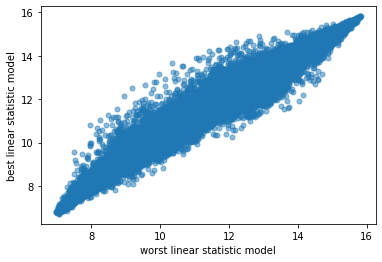

In [66]:
plt.scatter(worst_preds, best_preds, s=25, alpha=0.5)
plt.xlabel('worst linear statistic model')
plt.ylabel('best linear statistic model')

print('PCC', stats.pearsonr(worst_preds.astype('float32'), best_preds.astype('float32'))[0])

In [2]:
def from_json(json_file='pred_convnext_regularizer.json'):
	with open(json_file, 'r') as f:
		ground = json.load(f)
	indices = np.array([indice for indice in list(ground.values())])
 
	return indices

In [4]:
m1 = from_json('residual_transformer_modified.json')
m2 = from_json('mean_all_good.json')

FileNotFoundError: [Errno 2] No such file or directory: 'modified_residual_transformer.json'

PCC 0.9999999999999962


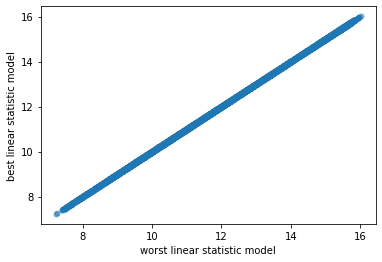

In [6]:
plt.scatter(m1, m2, s=25, alpha=0.5)
plt.xlabel('worst linear statistic model')
plt.ylabel('best linear statistic model')

print('PCC', stats.pearsonr(m1.astype('float32'), m2.astype('float32'))[0])

In [21]:
print(m1.shape, preds.shape)

(9045,) (71103,)


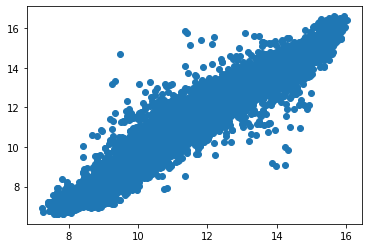

In [23]:
plt.scatter(m1, from_json(f'{model_name}.json'))